# Modelling

## Modules and Packages

In [ ]:
from statistics import stdev
from traceback import print_tb
!pip install statsmodels maidenhead cartopy matplotlib numpy statistics seaborn pandas
!pip install haversine

In [ ]:
import statsmodels.api as sm
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import maidenhead as mh
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import statistics
#import statsmodels as sm
import scipy.stats as stats
from haversine import haversine, Unit

## Importing Data

In [ ]:
header_df = pd.read_pickle("../Data/Pre-Processed/header_updated.pickle")

# Clean up header data

cols_to_upper = ['CATEGORY-ASSISTED','CATEGORY-POWER']
for col in cols_to_upper:
    header_df[col] = header_df[col].str.upper()


In [ ]:
categories_of_interest = ['CALLSIGN', 'CATEGORY-OPERATOR', 'CATEGORY-ASSISTED', 'CATEGORY-BAND', 'CATEGORY-POWER', 'CATEGORY-TRANSMITTER', 'CLAIMED-SCORE','GRID-LOCATOR', 'QSO_COUNT']
header_df = header_df[categories_of_interest]
header_df = header_df[header_df['QSO_COUNT'] != 0]

In [ ]:
logs = pd.read_pickle("../Data/Pre-Processed/logs.pickle")

# Clean up log data

log_cols_to_upper = ['sent_call', 'rcvd_call']
for col in log_cols_to_upper:
    logs[col] = logs[col].str.upper()


In [ ]:
data = header_df['QSO_COUNT']

### Note to self 

Data Quality - investigate issues and impact of these errors - Although so far we havent used rcvd callsign maybe errors are there

## QSO Count Distributions

In [ ]:
data.describe()

### visual inspection (EDA again)

#### Histogram (RAW)

In [ ]:
mod = statistics.mode(data=data)
print(mod)

In [ ]:
# Settin Bin Width using Freedman - Diaconis rule

data = header_df['QSO_COUNT']
q25, q75 = np.percentile(data, (25, 75))
IQR = q75 - q25

n = len(data)

bin_w = ((2 * IQR) / n ** (1/3))

# Number of bins

range = np.max(data) - np.min(data)
bins = round(range/bin_w)
print(bins)

In [ ]:
# Plotting Histogram

plt.figure(figsize=(10,5))
sns.histplot(data = data, bins = 304)
plt.title('Histogram of QSO Count')
plt.xlabel('QSO Count')
plt.ylabel('Frequency')
plt.show()

##### self notes

* heavily rightly skewed
* No local nodes (except initial dominant peak - global mode)
* Value Concentrated around 0 (Note - data is filtered to remove 0 from data since individual inspection suggests error in data entry) - so this entails bias.

#### KDE

In [ ]:
#plotting KDE

plt.figure(figsize=(10,5))
sns.kdeplot(data = header_df, x='QSO_COUNT', bw_adjust=0.2)
plt.title("Kernel Density Estimate of QSO_COUNT")
plt.xlabel("QSO_COUNT")
plt.ylabel("Density")
plt.show()

#### Log transformation

In [ ]:
# Log transformation

header_df['LOG_QSO_COUNT'] = np.log1p(header_df['QSO_COUNT'])

data_log = header_df['LOG_QSO_COUNT']

In [ ]:
# Settin Bin Width using Freedman - Diaconis rule

q25, q75 = np.percentile(data_log, (25, 75))
IQR = q75 - q25

n = len(data_log)

bin_w = ((2 * IQR) / n ** (1/3))

# Number of bins

range = np.max(data_log) - np.min(data_log)
bins = round(range/bin_w)

print(bins)

In [ ]:
# Plotting Histogram

plt.figure(figsize=(10,5))
plt.hist(data_log,bins = bins, density = True)
plt.title('Histogram of Log(QSO Count)')
plt.xlabel('Log(QSO Count)')
plt.ylabel('Frequency')
plt.show()

##### Self notes

* Gaussian distribution, bell curve
* unimodal
* Approximating a log normal distribution

In [ ]:
# KDE for Log transformed

plt.figure(figsize=(10,5))
sns.kdeplot(data = data_log, bw_adjust = 1)
plt.title('KDE of Log(QSO Count)')
plt.xlabel('Log(QSO Count)')
plt.ylabel('Frequency')
plt.show()

##### QQ Plot

In [ ]:
# Checking for Normality using QQ Plot

stats.probplot(data_log, dist="norm", plot=plt)
plt.title("QQ Plot of log-transformed QSO Counts")
plt.show()

* Strong evidence of normality
* lower tail suggesting a bit of skew
* upper tail also slightly deviates

#### ECDF

In [ ]:
# Plotting an ECDF

sns.ecdfplot(data_log)
plt.title("ECDF Plot of log-transformed QSO Counts")
plt.show()

### Distribution and goodness of fit for log normal

Assumed distribution is Log Normal

#### Distribution fitting

In [ ]:
# fitting a log normal to original count

shape, loc, scale = stats.lognorm.fit(data, floc=0)

# Generated data based on fitted distribution

x = np.linspace(data.min(), data.max(), 1000)
fitted_pdf = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)

In [ ]:
plt.figure(figsize=(10,5))

plt.hist(data, bins=304, density= True, label="RAW QSO Counts")
plt.plot(x, fitted_pdf, 'r-',label="Fitted log normal distribution")
plt.xlabel('QSO Count')
plt.ylabel('Density')
plt.title('Fitted Lognormal vs Empirical Distribution')
plt.legend()
plt.show()

In [ ]:
#plotting KDE

plt.figure(figsize=(10,5))
sns.kdeplot(data = header_df, x='QSO_COUNT', bw_adjust=0.2)
plt.plot(x, fitted_pdf, 'r-',label="Fitted log normal distribution")
plt.title("Kernel Density Estimate of QSO_COUNT")
plt.xlabel("QSO_COUNT")
plt.ylabel("Density")
#plt.xlim(0, 2500)
plt.show()

#### Goodness of fit

Going to do a Chi - Squared Goodness of Fit test on the histogram bands. Current data to be used for observed frequency. Will calculate Expected Frequency based on Fitted distribution. I'm doing a quantile based binning because raw data is too skewed.

##### Chi squared test (on the bins)

In [ ]:
# Quantile based binning and storing intervals

header_df['bin'] = pd.qcut(header_df['QSO_COUNT'], q = 10)

# Observed frequency

intervals = sorted(header_df['bin'].unique())
observed_frequency = np.zeros(len(intervals))

for i, interval in enumerate(intervals):
    for _ in header_df['bin']:
        if _ == interval:
            observed_frequency[i] += 1

intervals

In [ ]:
# Expected frequencies


prob = []

for interval in intervals:
    left = interval.left
    right = interval.right

    p1 = stats.lognorm.cdf(right, shape, loc=loc, scale=scale)
    p2 = stats.lognorm.cdf(left, shape, loc=loc, scale=scale)
    p = p1 - p2

    prob.append(p)

prob = np.array(prob)/sum(prob)

expected_frequency = np.array(prob)*n
expected_frequency



In [ ]:
statistic, pvalue = stats.chisquare(observed_frequency, expected_frequency, ddof= 6)

print(f"Chi-square test statistic: {statistic}, and p-value: {pvalue}")

P value is too less, reject H0 - distribution does not fit the data well enough :(

##### ks test

In [ ]:
ks_data = header_df['QSO_COUNT'].values

def cdf_fitted(x, shape = shape, loc = loc, scale = scale):
    '''
    cdf of lognormal distribution with pre set shape, loc, and scale
    '''
    return stats.lognorm.cdf(x, shape, loc=loc, scale=scale)

kstest, ks_pvalue = stats.kstest(ks_data, cdf_fitted)
print(f"KS test statistic: {ks_pvalue}, and p-value: {kstest}")


Again reject null hypothesis, p value < 0.05 :( - evidently lognormal is not a good fit

### Distribution and goodness of fit Negative binomial

In [ ]:
# fitting negative binomial



## GLM

#### Approach

In [ ]:
header_df = pd.read_pickle("../Data/Pre-Processed/header_updated.pickle")

# Clean up header data

cols_to_upper = ['CATEGORY-ASSISTED','CATEGORY-POWER']
for col in cols_to_upper:
    header_df[col] = header_df[col].str.upper()
    
# remove rows with QSO_COUNT = 0
header_df = header_df[header_df['QSO_COUNT'] != 0]

In [ ]:
# Log transformation

header_df['LOG_QSO_COUNT'] = np.log1p(header_df['QSO_COUNT'])

data_log = header_df['LOG_QSO_COUNT']

In [ ]:
print(header_df.head())

In [ ]:
for col in header_df.columns:
    if header_df[col].dtype == 'object' or header_df[col].dtype.name == 'category':
        print(f"{col}: {header_df[col].nunique()} unique values")

In [ ]:
logs = pd.read_pickle("../Data/Pre-Processed/logs.pickle")

# Clean up log data

log_cols_to_upper = ['sent_call', 'rcvd_call']
for col in log_cols_to_upper:
    logs[col] = logs[col].str.upper()

In [ ]:
print(logs.head())

In [ ]:
defective_header = pd.read_pickle("../Data/Pre-Processed/header_updated.pickle")
deafective_headers = defective_header[defective_header['QSO_COUNT'] == 0]
defective_callsigns = deafective_headers['CALLSIGN'].unique()
defective_callsigns

good_callsigns = header_df[~header_df['CALLSIGN'].isin(defective_callsigns)]['CALLSIGN'].unique()

correct_logs = logs[logs['sent_call'].isin(good_callsigns)]

print(correct_logs.head())

print(correct_logs.shape)

In [ ]:


def freq_to_band(freq_khz):
    """
    Convert frequency in kHz to amateur radio band name.
    
    Parameters:
        freq_khz (float): Frequency in kilohertz.
        
    Returns:
        str: Band name (e.g., '20M', '40M') or 'UNKNOWN' if not matched.
    """
    if 1800 <= freq_khz <= 2000:
        return "160M"
    
    elif 3500 <= freq_khz <= 4000:
        return "80M"
    
    elif 7000 <= freq_khz <= 7300:
        return "40M"
    
    elif 14000 <= freq_khz <= 14350:
        return "20M"
    
    elif 21000 <= freq_khz <= 21450:
        return "15M"
    
    elif 28000 <= freq_khz <= 29700:
        return "10M"
    
    else:
        return "UNKNOWN"


def form_pairs(a, b):
    return tuple(sorted([a, b]))


logs   = correct_logs.copy()

# Convert frequency to float and band

logs['freq'] = logs['freq'].astype(float)  
logs['band']  = logs['freq'].apply(freq_to_band)  

# Form pairs of callsigns for each log entry

logs['pairs'] = logs.apply(lambda row: form_pairs(row['sent_call'], row['rcvd_call']), axis=1)

# Convert date and time to UTC datetime and create 15-minute slices

logs['utc_dt'] = pd.to_datetime(logs['date'] + logs['time'], format='%Y-%m-%d%H%M')
logs['slice']  = logs['utc_dt'].dt.floor('15min')   

# Create a DataFrame with unique pairs and their corresponding band and slice
 
pos = logs[['sent_call', 'rcvd_call','pairs','band','slice']]
pos = pos.drop_duplicates(subset=['pairs', 'band', 'slice'])
pos['Y'] = 1



In [ ]:
print(pos.head())
print(pos.shape)

In [ ]:
print(pos.shape)

In [ ]:
print(header_df.head())

In [ ]:
h = header_df[['CALLSIGN','CATEGORY-POWER','CATEGORY-OPERATOR',
               'CATEGORY-ASSISTED','CATEGORY-TRANSMITTER',
               'GRID-LOCATOR','LOG_QSO_COUNT']]
pos = (pos
       .merge(h, left_on='sent_call', right_on='CALLSIGN', suffixes=('','_TX'))
       .merge(h, left_on='rcvd_call', right_on='CALLSIGN', suffixes=('','_RX')))

print(pos.head())
print(pos.shape)

In [ ]:
print(pos.columns)

#### ignore

In [ ]:
print(h.shape)

In [ ]:
plt.figure(figsize=(14, 5))
plt.hist(logs['freq'].astype(float), bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Count')
plt.title('Histogram of Frequency')
plt.xticks(np.arange(int(logs['freq'].astype(float).min()), 
                     int(logs['freq'].astype(float).max())+1, 1000), rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
logs.columns

In [ ]:
# Callsigns in correct_logs not found in header_df
missing_sent = pos[~pos['sent_call'].isin(header_df['CALLSIGN'])]
print(f"Missing sender callsigns: {missing_sent.shape[0]} rows")


In [ ]:
missing_rcvd = pos[~pos['rcvd_call'].isin(header_df['CALLSIGN'])]
print(f"Missing receiver callsigns: {missing_rcvd.shape[0]} rows")

print(len(missing_rcvd['rcvd_call'].unique()))

print(62583 - len(missing_rcvd['rcvd_call'].unique()))

#### approach continued

In [ ]:
print(pos.columns)

In [ ]:
print(pos['slice'].head(100))

In [ ]:
def safe_maidenhead_distance(locator1, locator2):
    """
    Calculate the distance between two Maidenhead locators.
    
    Parameters:
        locator1 (str): First Maidenhead locator.
        locator2 (str): Second Maidenhead locator.
        
    Returns:
        float: Distance in kilometers, or None if either locator is invalid.
    """
    try:
        if pd.isna(locator1) or pd.isna(locator2):
            return np.nan
        coord1 = mh.to_location(locator1, center=True)
        coord2 = mh.to_location(locator2, center=True)
        return haversine(coord1, coord2)
    except Exception:
        return np.nan
    
pos['distance'] = pos.apply(lambda row: safe_maidenhead_distance(row['GRID-LOCATOR'], row['GRID-LOCATOR_RX']), axis=1)

In [ ]:
print(pos['distance'].head(100))

In [ ]:
def midpoint_solar_time(utc_timestamp, loc1, loc2):
    """
    Calculate the midpoint solar time between two locations based on their Maidenhead locators.
    
    Parameters:
        utc_timestamp (pd.Timestamp): UTC timestamp of the QSO.
        loc1 (str): Maidenhead locator of the first station.
        loc2 (str): Maidenhead locator of the second station.
        
    Returns:
        pd.Timestamp: local solar time at the midpoint.
        Returns pd.NaT if locators are invalid.
    """
    try:
        coord1 = mh.to_location(loc1, center=True)
        coord2 = mh.to_location(loc2, center=True)
        
        # Calculate midpoint coordinates
        mid_lat = (coord1[0] + coord2[0]) / 2
        mid_lon = (coord1[1] + coord2[1]) / 2
        
        # Convert to datetime
        return utc_timestamp + pd.Timedelta(hours=(mid_lon / 15))
    except Exception as e:
        return pd.NaT

In [ ]:
pos['midpoint_solar_time'] = pos.apply(lambda row: midpoint_solar_time(row['slice'], row['GRID-LOCATOR'], row['GRID-LOCATOR_RX']), axis=1)

In [ ]:
print(pos.head())
print(pos.shape)

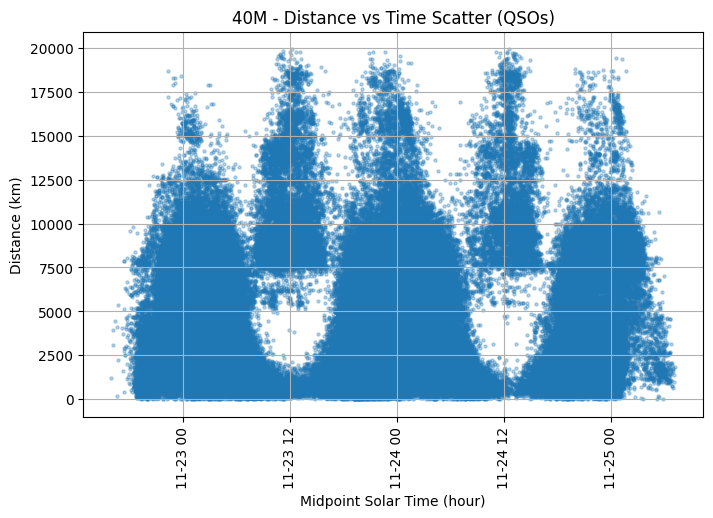

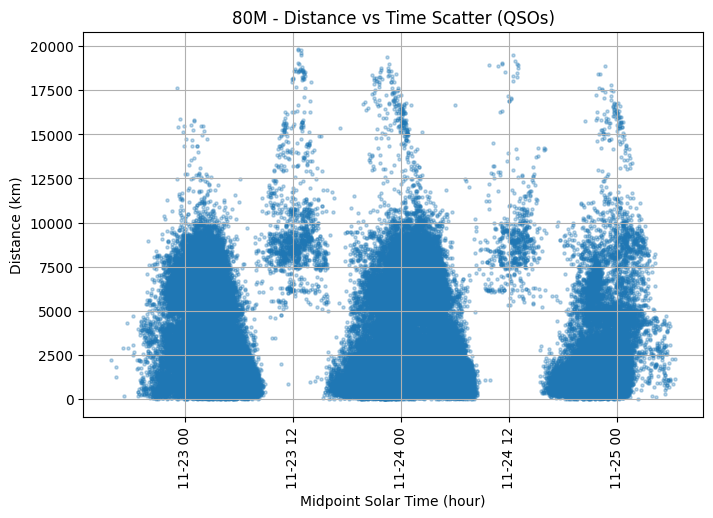

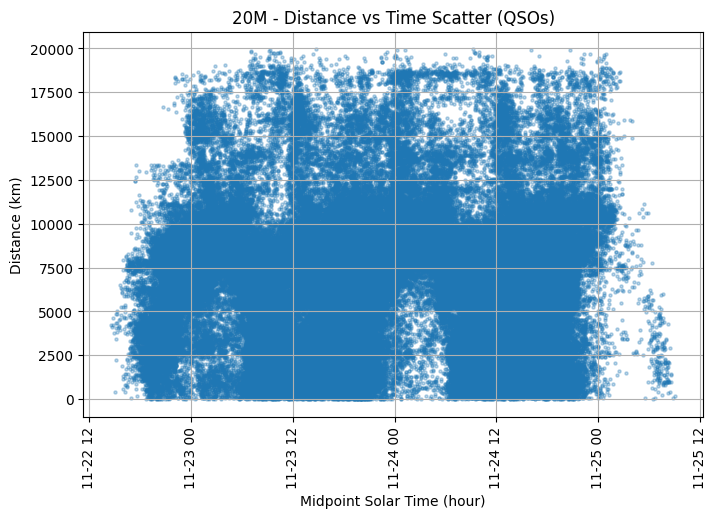

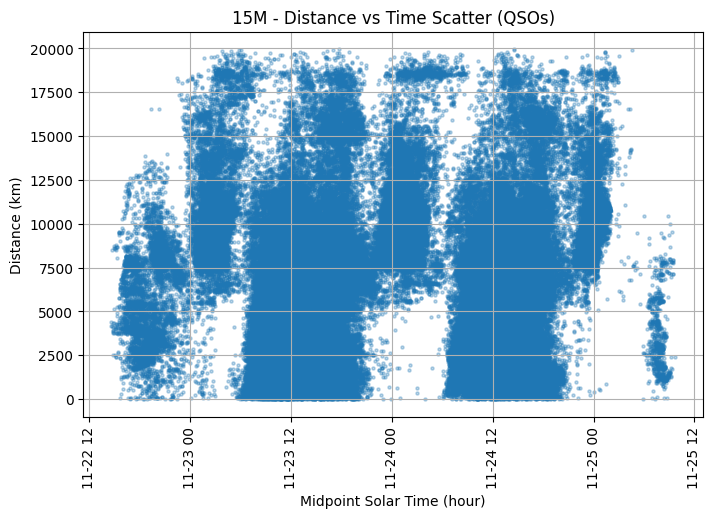

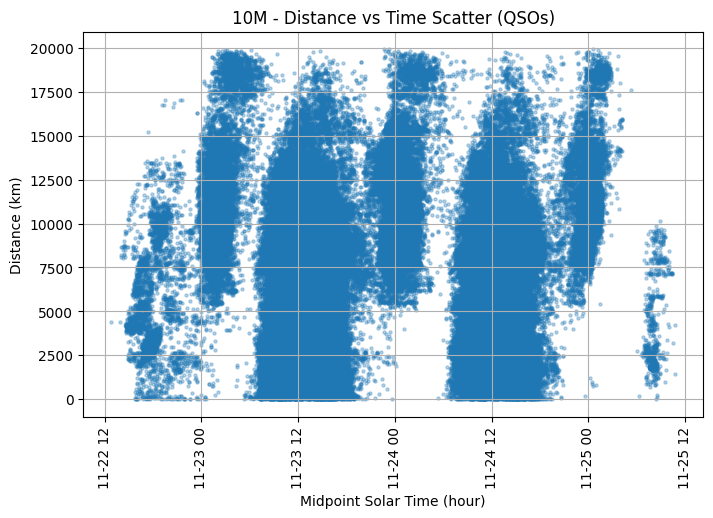

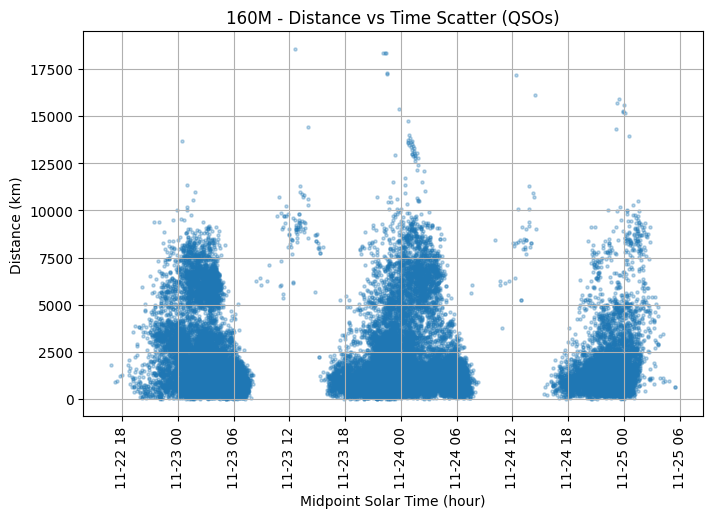

In [67]:
bands = pos['band'].unique()

for band in bands:
    df_band = pos[(pos['band'] == band) & (pos['distance'].notnull()) & (pos['midpoint_solar_time'].notnull())]

    plt.figure(figsize=(8,5))
    plt.scatter(df_band['midpoint_solar_time'], df_band['distance'], alpha=0.3, s=5)
    plt.xticks(rotation=90)
    plt.xlabel('Midpoint Solar Time (hour)')
    plt.ylabel('Distance (km)')
    plt.title(f'{band} - Distance vs Time Scatter (QSOs)')
    plt.grid(True)
    plt.show()

In [ ]:
# random sampling 

from random import sample
from xml.etree.ElementInclude import include


bands = pos['band'].unique()

def sample_by_band(df, n_samples = 20000, seed = 42):
    """
    Return a dataframe with up to `n_per_band` rows for every distinct `band`.
    Keeps the sample balanced so each band is equally represented.

    Args:
        df (_type_): _description_
        n_samples (int, optional): _description_. Defaults to 20000.
        seed (int, optional): _description_. Defaults to 42.
    """
    
    rng = np.random.default_rng(seed)
    grouped = df.groupby('band', group_keys=False)
    
    def _sample(group):
        if len(group) > n_samples:
            return group.sample(n=n_samples, random_state=rng)
        else:
            return group
        
    sampled = grouped.apply(_sample)
    return sampled.reset_index(drop=True)

qso_sampled = sample_by_band(pos)

In [ ]:
# Implementing Warped epanechnikov kernel

def circular_distance(t, t_i, period = 24.0):
    dt = np.abs(t - t_i)
    dt = np.minimum(dt, period - dt)  # Ensure circular distance
    return dt

def epan(u):
    mask = np.abs(u) <= 1
    out = np.zeros_like(u, dtype=float)
    out[mask] = 0.75 * (1 - u[mask] ** 2)
    return out

def kde2d_warped_epan(time, dist, grid_t, grid_d, h_t, h_d):
    """
    Perform 2D kernel density estimation with warped Epanechnikov kernel.
    
    Parameters:
        time (np.ndarray): Time data.
        dist (np.ndarray): Distance data.
        grid_t (np.ndarray): Grid for time.
        grid_d (np.ndarray): Grid for distance.
        h_t (float): Bandwidth for time.
        h_d (float): Bandwidth for distance.
        
    Returns:
        density: 2D array of estimated densities.
    """
    n = len(time)
    T,D = np.meshgrid(grid_t, grid_d)
    G = np.zeros_like(T, dtype=float)
    
    for t, d in zip(time, dist):
        Kt = epan(circular_distance(T, t)/ h_t) / h_t
        Kd = epan((D - d) / h_d) / h_d
        G += Kt * Kd # product of the kernels
    G /= n  # Normalize by number of points
    density = G
    
    return density

In [ ]:
print(qso_sampled.columns)


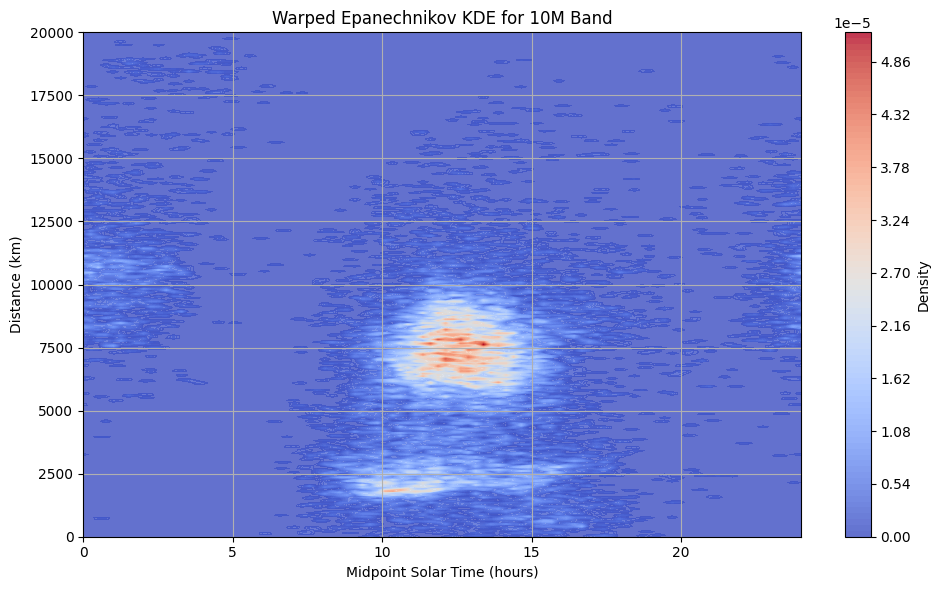

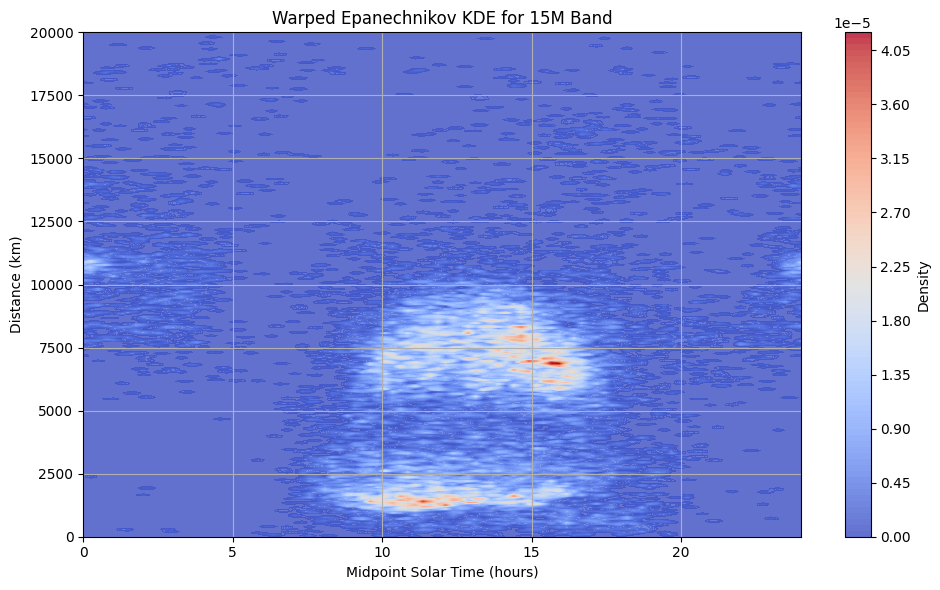

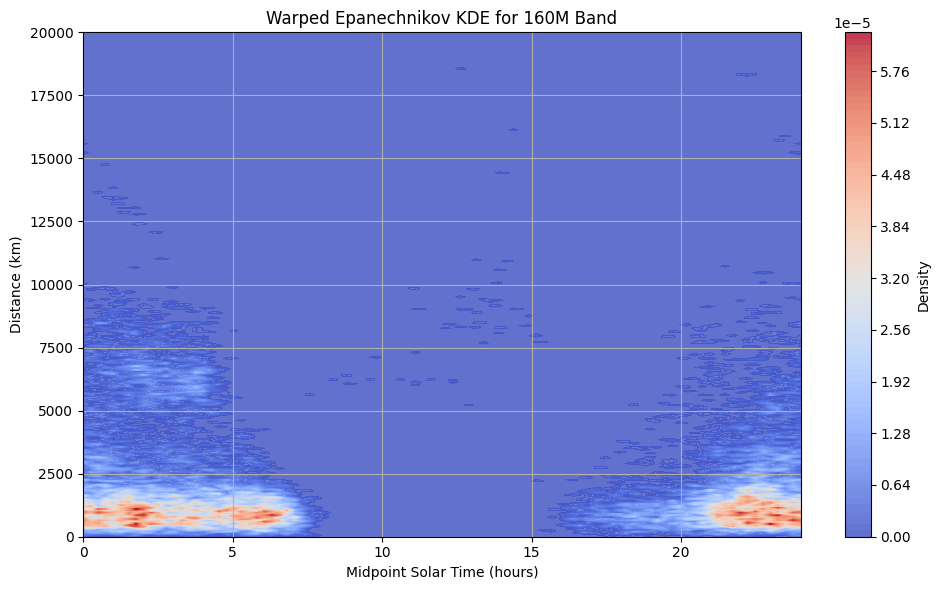

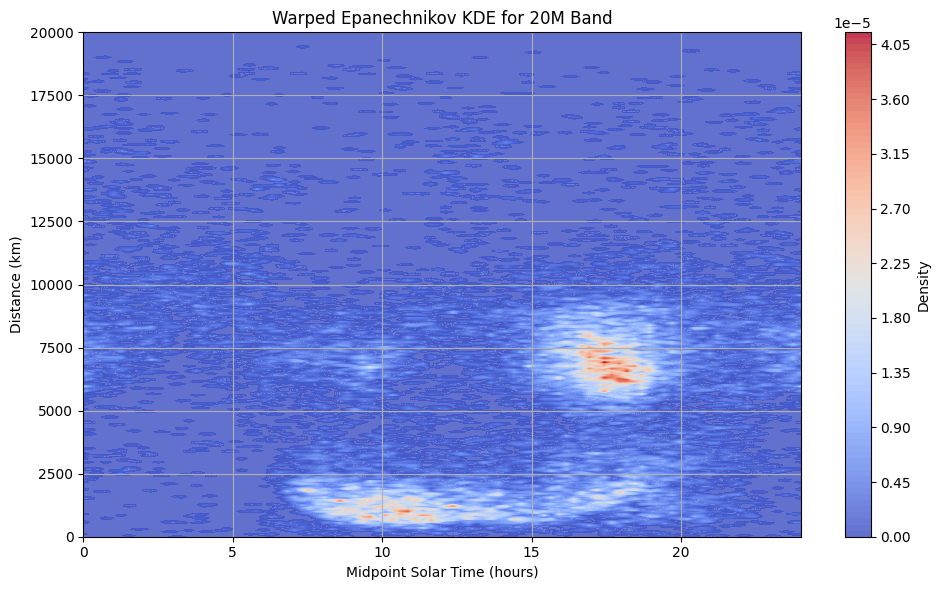

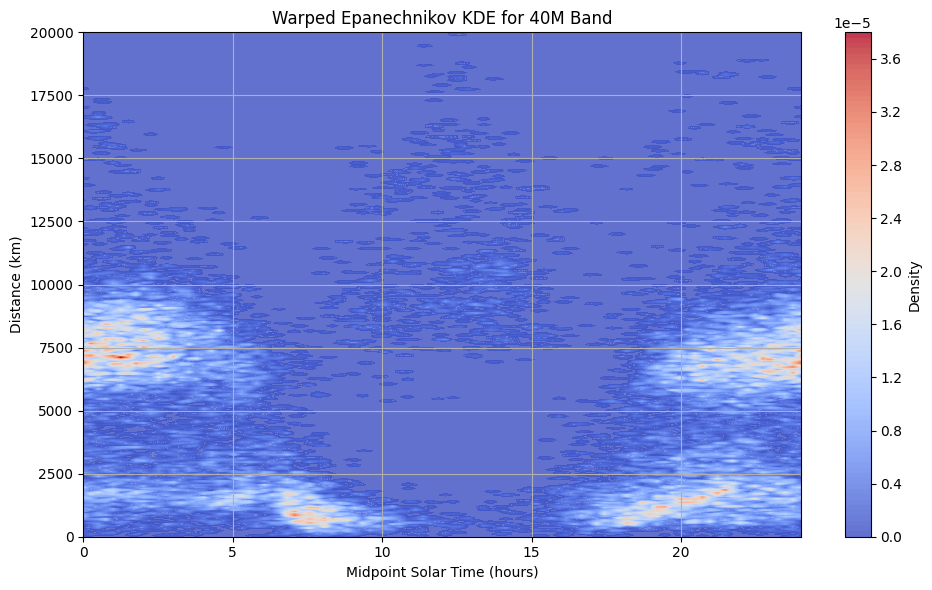

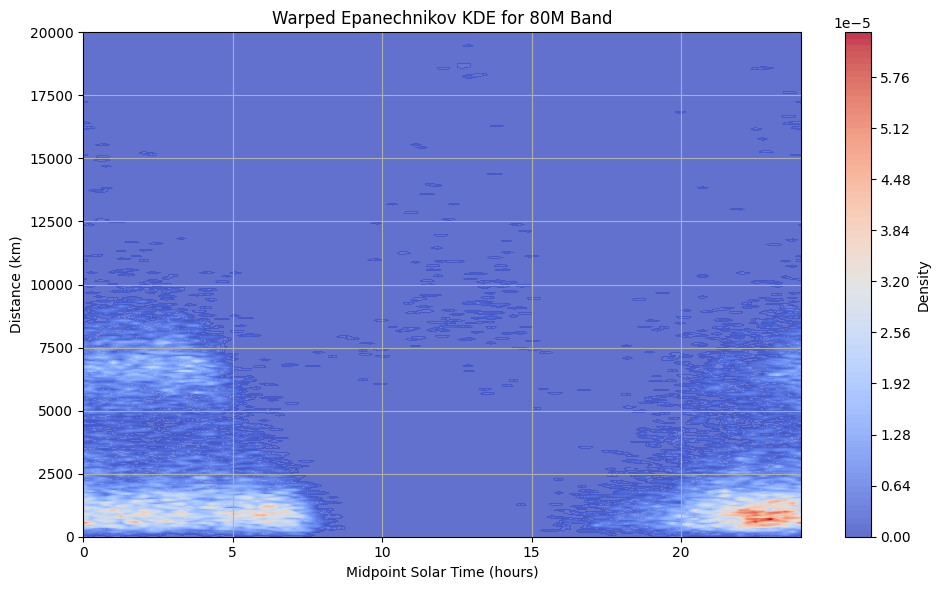

In [66]:

bands = qso_sampled['band'].unique()

for band in bands:
    df = qso_sampled[qso_sampled['band'] == band]

    time_vec = (df['midpoint_solar_time'].dt.hour
            + df['midpoint_solar_time'].dt.minute / 60
            + df['midpoint_solar_time'].dt.second / 3600).to_numpy()

    dist_vec = df['distance'].to_numpy()

    grid_t = np.linspace(0, 24, 96)  # 24 hours
    grid_d = np.linspace(0, 20000, 400)  # Distance in km

    h_t = 0.25  # Bandwidth for time
    h_d = 50  # Bandwidth for distance

    density = kde2d_warped_epan(time_vec, dist_vec, grid_t, grid_d, h_t, h_d)

    T, D = np.meshgrid(grid_t, grid_d)
    plt.figure(figsize=(10, 6))
    pcm = plt.contourf(T, D, density, levels=100, cmap='coolwarm', alpha=0.8)
    plt.xlabel('Midpoint Solar Time (hours)')
    plt.ylabel('Distance (km)')
    plt.title(f'Warped Epanechnikov KDE for {band} Band')
    plt.colorbar(pcm, label='Density')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
bands = ['40M']
for band in bands:
    df_band = pos[(pos['band'] == band) & (pos['distance'].notnull()) & (pos['midpoint_solar_time'].notnull())]
    
    time_in_hours = (
        df_band['midpoint_solar_time'].dt.hour +
        df_band['midpoint_solar_time'].dt.minute / 60 +
        df_band['midpoint_solar_time'].dt.second / 3600
    )

    x = time_in_hours.values   # Time as float
    y = df_band['distance'].values
    
    xy = np.vstack([x, y])
    
    kde = stats.gaussian_kde(xy)
    
    grid_x = np.linspace(0, 24, 96)       # Time grid (x-axis)
    grid_y = np.linspace(0, 20000, 400)   # Distance grid (y-axis)

    X, Y = np.meshgrid(grid_x, grid_y)

    grid_points = np.vstack([X.ravel(), Y.ravel()])   # Time first, distance second

    kde_values = kde(grid_points).reshape(X.shape)
    plt.figure(figsize=(8,5))
    plt.contourf(X, Y, kde_values, levels=100, cmap='hot')
    plt.xlabel('Midpoint Solar Time (hour)')
    plt.ylabel('Distance (km)')
    plt.title(f'{band} - KDE of Actual QSOs')
    plt.colorbar(label='Density of QSOs')
    plt.show()


    